In [33]:
import os
import copy
import math
import numpy as np 
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Improt dataset

In [34]:
import pandas as pd
data=pd.read_csv("1.csv",header=None)
data=data.values
#d = np.concatenate(([data[0]],data[1:3]),axis=0)
#print(d)
print(data.shape)
node_feats = np.zeros((10000,9,5))
label = np.zeros((10000,9,2))
count = 0
for row in data[0:10000]:
    t1 = 0.1*row[0:9]
    t2 = row[9:18]
    l1 = row[18:27]
    c1 = 0.001*row[27:36]
    c2 = 0.01*row[36:45]
    feas = np.array([t1, t2, l1, c1, c2]).T
    flow = row[45:]
    labels = np.array([[0.001*flow[0], 0.02*flow[1]],
                       [0.001*flow[2], 0],
                       [0.001*flow[3], 0.02*flow[4]],
                       [0.001*flow[5], 0],
                       [0.001*flow[6], 0],
                       [0.001*flow[7], 0.02*flow[8]],
                       [0.001*flow[9], 0],
                       [0.001*flow[10],0.02*flow[11]],
                       [0.001*flow[12],0]
                      ])
    node_feats[count] = feas
    label[count] = labels
    count = count + 1
node_feats = torch.Tensor(node_feats)
label = torch.Tensor(label)
print(node_feats[0],label[0])
print(node_feats[1],label[1])

adj_matrix = torch.Tensor([
    [0, 1, 1, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 1, 0, 0, 1, 0, 1],
    [1, 0, 0, 1, 1, 1, 0, 1, 0],
    [0, 1, 1, 0, 0, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 1, 0, 0, 1, 1, 0]])

(10000, 58)
tensor([[0.9815, 0.5792, 0.7743, 0.4597, 0.2425],
        [0.5906, 0.0000, 0.0000, 0.7016, 0.0000],
        [0.4127, 1.0959, 1.1392, 0.3097, 0.2467],
        [0.3913, 0.0000, 0.0000, 0.8096, 0.0000],
        [0.2632, 0.0000, 0.0000, 0.9049, 0.0000],
        [0.4098, 1.0656, 1.1655, 0.2080, 0.4339],
        [0.6278, 0.0000, 0.0000, 0.7014, 0.0000],
        [0.5547, 0.4036, 0.8171, 0.4042, 0.1379],
        [0.8957, 0.0000, 0.0000, 0.8092, 0.0000]]) tensor([[0.4460, 0.2124],
        [0.4566, 0.0000],
        [0.5768, 1.2455],
        [0.9773, 0.0000],
        [1.3776, 0.0000],
        [0.3286, 0.1924],
        [1.0394, 0.0000],
        [0.5152, 0.2295],
        [0.5267, 0.0000]])
tensor([[0.9706, 0.5709, 0.7960, 0.4503, 0.2327],
        [0.5032, 0.0000, 0.0000, 0.7044, 0.0000],
        [0.4277, 1.0755, 1.1340, 0.3038, 0.2081],
        [0.3046, 0.0000, 0.0000, 0.8077, 0.0000],
        [0.2097, 0.0000, 0.0000, 0.9079, 0.0000],
        [0.4823, 1.0276, 1.1585, 0.2019, 0.4060],
  

## Adaptive adjacency matrix and GCN

In [35]:
class GraphConv(nn.Module):
    
    def __init__(self, c_in, c_out, bias=True):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
        """
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(c_in, c_out))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(c_out))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
        self.nodevec1 = nn.Parameter(torch.randn(9, 5), requires_grad=True)
        self.nodevec2 = nn.Parameter(torch.randn(5, 9), requires_grad=True)
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, node_feats, adj_matrix):
        adj_matrix = F.softmax(F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)
        support = torch.mm(node_feats, self.weight)
        output = torch.spmm(adj_matrix, support)
        deg = torch.diag(adj_matrix.sum(1))
        out = torch.mm(torch.inverse(deg),output)
        if self.bias is not None:
            return out + self.bias, adj_matrix
        else:
            return out, adj_matrix

In [36]:

class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat
        
        self.W = nn.Parameter(torch.Tensor(in_features, out_features))
        self.a = nn.Parameter(torch.Tensor(2*out_features, 1))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    
    def forward(self, h, adj):
        '''
        h: (N, in_features)
        adj: sparse matrix with shape (N, N)
        '''
        
        Wh = torch.mm(h, self.W)  # (N, out_features)
        Wh1 = torch.mm(Wh, self.a[:self.out_features, :])  # (N, 1)
        Wh2 = torch.mm(Wh, self.a[self.out_features:, :])  # (N, 1)
        
        e = self.leakyrelu(Wh1 + Wh2.T)                    # (N, N)
        padding = (-2 ** 31) * torch.ones_like(e)          # (N, N)
        attention = torch.where(adj > 0, e, padding)       # (N, N)
        attention = F.softmax(attention, dim=1)            # (N, N)

        attention = F.dropout(attention, self.dropout, training=self.training)
        
        h_prime = torch.matmul(attention, Wh)              # (N, out_features)
        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime


class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        super(GAT, self).__init__()
        self.dropout = dropout
        self.MH = nn.ModuleList([
            GraphAttentionLayer(nfeat, nhid, dropout, alpha, concat=True)
            for _ in range(nheads)
        ])
        self.out_att = GraphAttentionLayer(nhid*nheads, nclass, dropout, alpha, concat=False)
        
    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)    # (N, nfeat)
        x = torch.cat([head(x, adj) for head in self.MH], dim=1)  # (N, nheads*nhid)
        x = F.dropout(x, self.dropout, training=self.training)    # (N, nheads*nhid)
        x = F.elu(self.out_att(x, adj))
        return x


In [37]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, nlayer):
        """
        Inputs:
            nfeat - Dimensionality of input features
            nhid - Dimensionality of hidden feature representation
            nclass - Number of classes
            nlayer - Number of layers
        """

        super(GCN, self).__init__()
        
        # A list of graph convolution layers
        self.convs = torch.nn.ModuleList([GraphConv(nfeat,nhid)]+[GraphConv(nhid,nhid) for i in range(nlayer-2)]+[GraphConv(nhid,nclass)])

        # The log softmax layer
        self.softmax = torch.nn.LogSoftmax()
        
    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj):
        # TODO: Implement a function that takes the node features x and
        # adjacency matrix adj and returns the predicted labels.

        out = None
        out = x
        n = len(self.convs)
        adj_list = []
        for layer in self.convs:
            n = n-1
            out,adj = layer(out,adj)
            adj_list.append(adj)
            if n > 0:
                out = torch.nn.functional.relu(out,0.001)
        return out,adj_list

In [38]:
args = {
        'device': torch.cuda.is_available(),
        'num_layers': 2, #GCN 2
        'hidden_dim': 32,
        'lr': 0.0001, #0.00005
        'weight_decay': 5e-4,
        'epochs': 200,
        'fastmode': False
    }

model = GCN(nfeat=node_feats.shape[2],
            nhid=args['hidden_dim'],
            nclass=2,
            nlayer=args['num_layers'])

#model = nfeat, nhid, nclass, dropout, alpha, nheads
#model = GAT(nfeat=node_feats.shape[2],
#            nhid=args['hidden_dim'],
#            nclass=2,
#            dropout = 0,
#            alpha = 0.2,
#            nheads = 5) #2

# optimizers
#optimizer = optim.Adam(model.parameters(),
#                       lr=args['lr'], weight_decay=args['weight_decay'])
#optimizer = optim.RMSprop(model.parameters(),
#                       lr=args['lr'], weight_decay=args['weight_decay'])
optimizer = optim.SGD(model.parameters(),
                       lr=args['lr'], weight_decay=args['weight_decay'])

In [39]:
if args['device']:
    model.cuda()
    node_feats = node_feats.cuda()
    adj_matrxi = adj_matrix.cuda()
    label = label.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

In [40]:
def train(epoch,ep_features,ep_labels):
    t = time.time()
    model.train()
    loss_function=torch.nn.MSELoss()
    optimizer.zero_grad()
    output,adj = model(ep_features[0],adj_matrix)
    output = output.unsqueeze(0)
    for i in range(1,16):
        output_,adj = model(ep_features[i],adj_matrix)
        output = torch.cat((output, output_.unsqueeze(0)), 0)
    #loss_train = torch.nn.functional.nll_loss(output[idx_train], labels[idx_train])
    #print(output, label)
    loss_train = loss_function(output, ep_labels)

    loss_train.backward()
    optimizer.step()

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
    #      'acc_train: {:.4f}'.format(acc_train.item()),
    #      'loss_val: {:.4f}'.format(loss_val.item()),
    #      'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return output,loss_train

def test():
    t_test = time.time()
    model.eval()
    loss_function=torch.nn.MSELoss()
    loss_mae = torch.nn.L1Loss()
    test_feats = node_feats[8000:9000]
    
    output,adj = model(test_feats[0],adj_matrix)
    print(output, label[8000])
    output = output.unsqueeze(0)
    for i in range(1,1000):
        output_,adj = model(test_feats[i],adj_matrix)
        output = torch.cat((output, output_.unsqueeze(0)), 0)

    #MSE
    MSEloss = loss_function(output, label[8000:9000])
    #MAE
    MAEloss =  loss_mae(output, label[8000:9000])
    #MAPE
    output = output.detach().numpy()
    label_cal_loss = label[8000:9000].numpy()
    MAPEloss = np.fabs((label_cal_loss-output)/np.clip(label_cal_loss,0.2,2)).mean()
 

    print(MSEloss, MAEloss, MAPEloss)
    print("Test set results:",
         'time: {:.4f}s'.format(time.time() - t_test))


In [41]:
t_total = time.time()
best_model = None
best_valid_acc = 0
loss_list = []
for epoch in range(args['epochs']):
    inner_loss_list = []
    for batch in range(300):
    #output, loss_ = train(epoch, node_feats[epoch%6000],label[epoch%6000])
        output, loss_ = train(epoch, node_feats[batch*16:(batch+1)*16],label[batch*16:(batch+1)*16])
        inner_loss_list.append(loss_.detach().float())
    loss_ep = sum(inner_loss_list)/len(inner_loss_list)
    loss_list.append(loss_ep)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
test()

Epoch: 0001 loss_train: 1.4623 time: 0.0118s
Epoch: 0001 loss_train: 1.4531 time: 0.0098s
Epoch: 0001 loss_train: 1.4665 time: 0.0064s
Epoch: 0001 loss_train: 1.4689 time: 0.0063s
Epoch: 0001 loss_train: 1.4636 time: 0.0059s
Epoch: 0001 loss_train: 1.4467 time: 0.0054s
Epoch: 0001 loss_train: 1.4423 time: 0.0054s
Epoch: 0001 loss_train: 1.4626 time: 0.0062s
Epoch: 0001 loss_train: 1.4415 time: 0.0049s
Epoch: 0001 loss_train: 1.4735 time: 0.0047s
Epoch: 0001 loss_train: 1.4570 time: 0.0043s
Epoch: 0001 loss_train: 1.4362 time: 0.0040s
Epoch: 0001 loss_train: 1.4551 time: 0.0037s
Epoch: 0001 loss_train: 1.4349 time: 0.0038s
Epoch: 0001 loss_train: 1.4492 time: 0.0035s
Epoch: 0001 loss_train: 1.4309 time: 0.0033s
Epoch: 0001 loss_train: 1.4809 time: 0.0032s
Epoch: 0001 loss_train: 1.4313 time: 0.0032s
Epoch: 0001 loss_train: 1.4300 time: 0.0032s
Epoch: 0001 loss_train: 1.4644 time: 0.0032s
Epoch: 0001 loss_train: 1.4461 time: 0.0032s
Epoch: 0001 loss_train: 1.4629 time: 0.0031s
Epoch: 000

Epoch: 0001 loss_train: 1.2083 time: 0.0035s
Epoch: 0001 loss_train: 1.1923 time: 0.0032s
Epoch: 0001 loss_train: 1.2068 time: 0.0032s
Epoch: 0001 loss_train: 1.1951 time: 0.0032s
Epoch: 0001 loss_train: 1.1943 time: 0.0033s
Epoch: 0001 loss_train: 1.1874 time: 0.0032s
Epoch: 0001 loss_train: 1.2048 time: 0.0033s
Epoch: 0001 loss_train: 1.1947 time: 0.0035s
Epoch: 0001 loss_train: 1.2038 time: 0.0034s
Epoch: 0001 loss_train: 1.2172 time: 0.0032s
Epoch: 0001 loss_train: 1.2032 time: 0.0031s
Epoch: 0001 loss_train: 1.1886 time: 0.0032s
Epoch: 0001 loss_train: 1.1813 time: 0.0031s
Epoch: 0001 loss_train: 1.2162 time: 0.0032s
Epoch: 0001 loss_train: 1.1803 time: 0.0032s
Epoch: 0001 loss_train: 1.1824 time: 0.0031s
Epoch: 0001 loss_train: 1.1937 time: 0.0033s
Epoch: 0001 loss_train: 1.1765 time: 0.0033s
Epoch: 0001 loss_train: 1.1762 time: 0.0032s
Epoch: 0001 loss_train: 1.1746 time: 0.0033s
Epoch: 0001 loss_train: 1.1872 time: 0.0032s
Epoch: 0001 loss_train: 1.1735 time: 0.0032s
Epoch: 000

Epoch: 0002 loss_train: 1.0368 time: 0.0036s
Epoch: 0002 loss_train: 1.0365 time: 0.0032s
Epoch: 0002 loss_train: 1.0323 time: 0.0031s
Epoch: 0002 loss_train: 1.0320 time: 0.0034s
Epoch: 0002 loss_train: 1.0504 time: 0.0033s
Epoch: 0002 loss_train: 1.0493 time: 0.0034s
Epoch: 0002 loss_train: 1.0308 time: 0.0036s
Epoch: 0002 loss_train: 1.0476 time: 0.0035s
Epoch: 0002 loss_train: 1.0338 time: 0.0034s
Epoch: 0002 loss_train: 1.0267 time: 0.0033s
Epoch: 0002 loss_train: 1.0276 time: 0.0034s
Epoch: 0002 loss_train: 1.0283 time: 0.0032s
Epoch: 0002 loss_train: 1.0406 time: 0.0035s
Epoch: 0002 loss_train: 1.0410 time: 0.0032s
Epoch: 0002 loss_train: 1.0262 time: 0.0034s
Epoch: 0002 loss_train: 1.0252 time: 0.0032s
Epoch: 0002 loss_train: 1.0272 time: 0.0032s
Epoch: 0002 loss_train: 1.0206 time: 0.0035s
Epoch: 0002 loss_train: 1.0192 time: 0.0032s
Epoch: 0002 loss_train: 1.0221 time: 0.0035s
Epoch: 0002 loss_train: 1.0223 time: 0.0033s
Epoch: 0002 loss_train: 1.0206 time: 0.0032s
Epoch: 000

Epoch: 0003 loss_train: 0.8868 time: 0.0035s
Epoch: 0003 loss_train: 0.8696 time: 0.0032s
Epoch: 0003 loss_train: 0.8709 time: 0.0032s
Epoch: 0003 loss_train: 0.8909 time: 0.0032s
Epoch: 0003 loss_train: 0.8841 time: 0.0033s
Epoch: 0003 loss_train: 0.8685 time: 0.0033s
Epoch: 0003 loss_train: 0.8679 time: 0.0033s
Epoch: 0003 loss_train: 0.8668 time: 0.0035s
Epoch: 0003 loss_train: 0.8821 time: 0.0035s
Epoch: 0003 loss_train: 0.8715 time: 0.0032s
Epoch: 0003 loss_train: 0.8660 time: 0.0032s
Epoch: 0003 loss_train: 0.8620 time: 0.0033s
Epoch: 0003 loss_train: 0.9163 time: 0.0035s
Epoch: 0003 loss_train: 0.8625 time: 0.0032s
Epoch: 0003 loss_train: 0.8801 time: 0.0033s
Epoch: 0003 loss_train: 0.8813 time: 0.0033s
Epoch: 0003 loss_train: 0.8605 time: 0.0033s
Epoch: 0003 loss_train: 0.8608 time: 0.0034s
Epoch: 0003 loss_train: 0.8783 time: 0.0032s
Epoch: 0003 loss_train: 0.8730 time: 0.0033s
Epoch: 0003 loss_train: 0.8760 time: 0.0034s
Epoch: 0003 loss_train: 0.8726 time: 0.0033s
Epoch: 000

Epoch: 0003 loss_train: 0.7764 time: 0.0035s
Epoch: 0003 loss_train: 0.7704 time: 0.0032s
Epoch: 0003 loss_train: 0.8037 time: 0.0032s
Epoch: 0003 loss_train: 0.7699 time: 0.0032s
Epoch: 0003 loss_train: 0.7723 time: 0.0033s
Epoch: 0003 loss_train: 0.7842 time: 0.0032s
Epoch: 0003 loss_train: 0.7679 time: 0.0033s
Epoch: 0003 loss_train: 0.7678 time: 0.0035s
Epoch: 0003 loss_train: 0.7668 time: 0.0032s
Epoch: 0003 loss_train: 0.7793 time: 0.0032s
Epoch: 0003 loss_train: 0.7665 time: 0.0032s
Epoch: 0003 loss_train: 0.7659 time: 0.0032s
Epoch: 0003 loss_train: 0.7672 time: 0.0032s
Epoch: 0003 loss_train: 0.7783 time: 0.0033s
Epoch: 0003 loss_train: 0.7625 time: 0.0033s
Epoch: 0003 loss_train: 0.7652 time: 0.0033s
Epoch: 0003 loss_train: 0.7632 time: 0.0032s
Epoch: 0003 loss_train: 0.7639 time: 0.0032s
Epoch: 0003 loss_train: 0.7719 time: 0.0032s
Epoch: 0003 loss_train: 0.7612 time: 0.0032s
Epoch: 0003 loss_train: 0.7741 time: 0.0031s
Epoch: 0003 loss_train: 0.7627 time: 0.0032s
Epoch: 000

Epoch: 0004 loss_train: 0.7130 time: 0.0034s
Epoch: 0004 loss_train: 0.6988 time: 0.0032s
Epoch: 0004 loss_train: 0.6986 time: 0.0032s
Epoch: 0004 loss_train: 0.7008 time: 0.0032s
Epoch: 0004 loss_train: 0.6952 time: 0.0033s
Epoch: 0004 loss_train: 0.6944 time: 0.0033s
Epoch: 0004 loss_train: 0.6969 time: 0.0033s
Epoch: 0004 loss_train: 0.6980 time: 0.0034s
Epoch: 0004 loss_train: 0.6967 time: 0.0032s
Epoch: 0004 loss_train: 0.6979 time: 0.0032s
Epoch: 0004 loss_train: 0.6962 time: 0.0031s
Epoch: 0004 loss_train: 0.6936 time: 0.0033s
Epoch: 0004 loss_train: 0.6948 time: 0.0031s
Epoch: 0004 loss_train: 0.7098 time: 0.0031s
Epoch: 0004 loss_train: 0.7089 time: 0.0032s
Epoch: 0004 loss_train: 0.6930 time: 0.0032s
Epoch: 0004 loss_train: 0.7065 time: 0.0032s
Epoch: 0004 loss_train: 0.6919 time: 0.0032s
Epoch: 0004 loss_train: 0.7131 time: 0.0032s
Epoch: 0004 loss_train: 0.7139 time: 0.0032s
Epoch: 0004 loss_train: 0.7241 time: 0.0031s
Epoch: 0004 loss_train: 0.6895 time: 0.0032s
Epoch: 000

Epoch: 0005 loss_train: 0.6739 time: 0.0034s
Epoch: 0005 loss_train: 0.6418 time: 0.0032s
Epoch: 0005 loss_train: 0.6551 time: 0.0032s
Epoch: 0005 loss_train: 0.6739 time: 0.0032s
Epoch: 0005 loss_train: 0.6408 time: 0.0033s
Epoch: 0005 loss_train: 0.6707 time: 0.0033s
Epoch: 0005 loss_train: 0.6433 time: 0.0033s
Epoch: 0005 loss_train: 0.6546 time: 0.0033s
Epoch: 0005 loss_train: 0.6400 time: 0.0032s
Epoch: 0005 loss_train: 0.6596 time: 0.0032s
Epoch: 0005 loss_train: 0.6381 time: 0.0032s
Epoch: 0005 loss_train: 0.6386 time: 0.0032s
Epoch: 0005 loss_train: 0.6441 time: 0.0032s
Epoch: 0005 loss_train: 0.6351 time: 0.0032s
Epoch: 0005 loss_train: 0.6523 time: 0.0032s
Epoch: 0005 loss_train: 0.6359 time: 0.0032s
Epoch: 0005 loss_train: 0.6361 time: 0.0032s
Epoch: 0005 loss_train: 0.6520 time: 0.0031s
Epoch: 0005 loss_train: 0.6488 time: 0.0031s
Epoch: 0005 loss_train: 0.6371 time: 0.0032s
Epoch: 0005 loss_train: 0.6343 time: 0.0032s
Epoch: 0005 loss_train: 0.6572 time: 0.0032s
Epoch: 000

Epoch: 0005 loss_train: 0.6045 time: 0.0034s
Epoch: 0005 loss_train: 0.5926 time: 0.0032s
Epoch: 0005 loss_train: 0.6098 time: 0.0032s
Epoch: 0005 loss_train: 0.5889 time: 0.0032s
Epoch: 0005 loss_train: 0.5909 time: 0.0033s
Epoch: 0005 loss_train: 0.5894 time: 0.0033s
Epoch: 0005 loss_train: 0.5906 time: 0.0033s
Epoch: 0005 loss_train: 0.5896 time: 0.0034s
Epoch: 0005 loss_train: 0.5882 time: 0.0032s
Epoch: 0005 loss_train: 0.5888 time: 0.0032s
Epoch: 0005 loss_train: 0.5948 time: 0.0031s
Epoch: 0005 loss_train: 0.5885 time: 0.0031s
Epoch: 0005 loss_train: 0.5871 time: 0.0031s
Epoch: 0005 loss_train: 0.6134 time: 0.0031s
Epoch: 0005 loss_train: 0.5878 time: 0.0032s
Epoch: 0005 loss_train: 0.6262 time: 0.0032s
Epoch: 0005 loss_train: 0.5890 time: 0.0032s
Epoch: 0005 loss_train: 0.6168 time: 0.0033s
Epoch: 0005 loss_train: 0.6037 time: 0.0032s
Epoch: 0005 loss_train: 0.5875 time: 0.0032s
Epoch: 0005 loss_train: 0.6010 time: 0.0032s
Epoch: 0005 loss_train: 0.5870 time: 0.0032s
Epoch: 000

Epoch: 0006 loss_train: 0.5492 time: 0.0034s
Epoch: 0006 loss_train: 0.5486 time: 0.0032s
Epoch: 0006 loss_train: 0.5474 time: 0.0031s
Epoch: 0006 loss_train: 0.5637 time: 0.0033s
Epoch: 0006 loss_train: 0.5472 time: 0.0033s
Epoch: 0006 loss_train: 0.5460 time: 0.0033s
Epoch: 0006 loss_train: 0.5768 time: 0.0034s
Epoch: 0006 loss_train: 0.5462 time: 0.0032s
Epoch: 0006 loss_train: 0.5473 time: 0.0032s
Epoch: 0006 loss_train: 0.5496 time: 0.0032s
Epoch: 0006 loss_train: 0.5597 time: 0.0031s
Epoch: 0006 loss_train: 0.5461 time: 0.0032s
Epoch: 0006 loss_train: 0.5609 time: 0.0032s
Epoch: 0006 loss_train: 0.5457 time: 0.0032s
Epoch: 0006 loss_train: 0.5594 time: 0.0032s
Epoch: 0006 loss_train: 0.5667 time: 0.0031s
Epoch: 0006 loss_train: 0.5708 time: 0.0032s
Epoch: 0006 loss_train: 0.5445 time: 0.0031s
Epoch: 0006 loss_train: 0.5436 time: 0.0032s
Epoch: 0006 loss_train: 0.5411 time: 0.0032s
Epoch: 0006 loss_train: 0.5584 time: 0.0031s
Epoch: 0006 loss_train: 0.5424 time: 0.0032s
Epoch: 000

Epoch: 0006 loss_train: 0.5147 time: 0.0034s
Epoch: 0006 loss_train: 0.5104 time: 0.0031s
Epoch: 0006 loss_train: 0.5240 time: 0.0031s
Epoch: 0006 loss_train: 0.5088 time: 0.0032s
Epoch: 0006 loss_train: 0.5232 time: 0.0033s
Epoch: 0006 loss_train: 0.5068 time: 0.0033s
Epoch: 0006 loss_train: 0.5239 time: 0.0034s
Epoch: 0006 loss_train: 0.5256 time: 0.0036s
Epoch: 0006 loss_train: 0.5076 time: 0.0032s
Epoch: 0006 loss_train: 0.5064 time: 0.0032s
Epoch: 0006 loss_train: 0.5060 time: 0.0032s
Epoch: 0006 loss_train: 0.5236 time: 0.0033s
Epoch: 0006 loss_train: 0.5074 time: 0.0033s
Epoch: 0006 loss_train: 0.5071 time: 0.0032s
Epoch: 0006 loss_train: 0.5086 time: 0.0033s
Epoch: 0006 loss_train: 0.5313 time: 0.0032s
Epoch: 0006 loss_train: 0.5054 time: 0.0032s
Epoch: 0006 loss_train: 0.5052 time: 0.0032s
Epoch: 0006 loss_train: 0.5240 time: 0.0032s
Epoch: 0006 loss_train: 0.5194 time: 0.0032s
Epoch: 0007 loss_train: 0.5147 time: 0.0032s
Epoch: 0007 loss_train: 0.5070 time: 0.0032s
Epoch: 000

KeyboardInterrupt: 

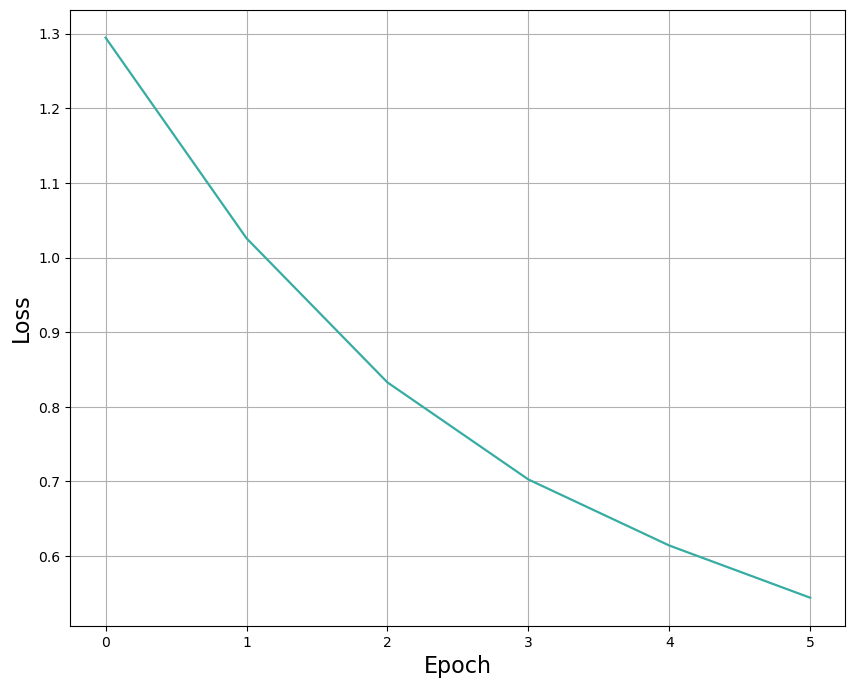

[array(1.2945472, dtype=float32), array(1.0258076, dtype=float32), array(0.83270615, dtype=float32), array(0.7026798, dtype=float32), array(0.6141661, dtype=float32), array(0.5442072, dtype=float32)]


In [42]:
loss_list_ = []
for i in loss_list:
    loss_list_.append(i.detach().numpy())
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(10,8))
#fig1.subplots_adjust(bottom = 0,wspace = 1)
ax1 = fig1.add_subplot(111)
ax1.plot(loss_list_, color='#36ACA2', linewidth=1.6)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_xlabel('Epoch',fontsize=16)
ax1.grid()
#plt.show()
plt.show()
print(loss_list_)